Code to add a VTA, dynamic dopamine release and simple reinforcement learning to the connectome-based dynamical model.

Sean Froudist-Walsh

In [1]:
# let's get what we need together
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import scipy.io as sio
import brian2
import os
import copy
import pickle



Define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{total,E} - b}{1 - e^{-d(aI_{total,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = c_II_{total,I} + r_0 & \text{for } I_{total,I}\ge -r_0/c_I\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$


In [2]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_e']
        b = parameters['b_e']
        d = parameters['d_e']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'PV':
        c_I = parameters['c_I_pv']
        r_0 = parameters['r_0_pv']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'SST':
        c_I = parameters['c_I_sst']
        r_0 = parameters['r_0_sst']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'VIP':
        c_I = parameters['c_I_vip']
        r_0 = parameters['r_0_vip']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'DA':
        c_I = parameters['c_I_da']
        r_0 = parameters['r_0_da']
        r = np.maximum(c_I*input_current + r_0,0)
        return r


Define the current formulation of the dendrite input-output function (presuming $I_{inh}$ is negative)
<br>
<br>
$$ 
I_{soma,dendrite} = f_I(I_{exc},I_{inh}) = 
c_1.\biggl[\tanh\biggl(\dfrac{I_{exc} + c_3*I_{inh} + c_4}{c_5 e^{-I_{inh}/c6}}\biggr)\biggr] + c_2
$$

In [3]:
def dendrite_input_output(exc_current,inh_current,parameters):
    c1 = parameters['c1']
    c2 = parameters['c2']
    c3 = parameters['c3']
    c4 = parameters['c4']
    c5 = parameters['c5']
    c6 = parameters['c6']
    
    beta = c5*np.exp(-inh_current/c6)
    
    return c1*(np.tanh((exc_current +c3*inh_current + c4)/beta)) + c2

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + x_0u_0(1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [4]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_nmda'] + parameters['x0']*parameters['u0']*parameters['gamma_nmda']*(1 - S_NMDA_prev)*rate_now

Define the AMPA derivative 
<br>
$$ \frac{dS_{AMPA}}{dt} = -\frac{S_{AMPA}}{\tau_{AMPA}} + x_0u_0\gamma_{AMPA}r_E$$
(Wong & Wang, 2006)

In [5]:
def AMPA_deriv(S_AMPA_prev,rate_now,parameters):
    
    return -S_AMPA_prev/parameters['tau_ampa'] + parameters['x0']*parameters['u0']*parameters['gamma_ampa']*rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

Set the parameters

In [6]:
def GABA_deriv(S_GABA_prev,rate_now,parameters,cell_section):
    if cell_section == 'soma':
        return -S_GABA_prev/parameters['tau_gaba'] + parameters['gamma_gaba']*rate_now 
    elif cell_section == 'dendrite':
        return -S_GABA_prev/parameters['tau_gaba_dend'] + parameters['gamma_gaba']*rate_now

Define the adaptation current derivative
$$ \frac{dS_{a}}{dt} = -\frac{S_{a}}{\tau_{a}} + r $$
(Engel & Wang, 2001)

In [7]:
def adaptation_deriv(S_a_prev,rate_now,parameters):
    return -S_a_prev/parameters['tau_adapt'] + rate_now

Several of dopamine's effects are models with a sigmoid function (such as how release gets converted to fraction of occupied D1 receptors)

In [8]:
def sigmoid_DA(height,midpoint,slope):
     return np.exp(slope*(height-midpoint))/(1 + np.exp(slope*(height-midpoint)))


Define the dopamine concentration function
$$ \frac{d[DA]}{dt} = -\frac{[DA]}{\tau_{DA}} + \gamma_{DA}r_{VTA_{DA}} $$


In [9]:
def DAconc_deriv(DA_prev,DA_rate_now,parameters,brain_region):
    if brain_region == 'cortex':
        return -DA_prev/parameters['tau_DA_ctx'] + parameters['gamma_DA_ctx']*DA_rate_now
    elif brain_region == 'vta':
        return -DA_prev/parameters['tau_DA_vta'] + parameters['gamma_DA_vta']*DA_rate_now
    

Define the short-term facilitation (usage of synaptic resources - related to presynaptic calcium
$$ \frac{du}{dt} = \frac{U - u}{\tau_{u}} + U(1-u)r $$
(Mongillo et al., 2008)

In [10]:
def STF_deriv(rate_prev,u_prev,parameters):
    return (parameters['U_baseline'] - u_prev)/parameters['tau_u'] + parameters['U_baseline']*(1- u_prev)*rate_prev


Define the short-term depression (total store of available vesicles) - is depleted by u (usage)
$$ \frac{dx}{dt} = \frac{1 - x}{\tau_{x}} - uxr $$
(Mongillo et al., 2008)

In [11]:
def STD_deriv(rate_prev,x_prev,u_prev,parameters):
    return (1 - x_prev)/parameters['tau_x'] - u_prev*x_prev*rate_prev


Define the NMDA derivative with STP
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + xu(1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [12]:
def NMDA_deriv_STP(S_NMDA_prev,rate_now,parameters,u_prev):
    # STF only
    return -S_NMDA_prev/parameters['tau_nmda'] + parameters['x0']*u_prev*parameters['gamma_nmda']*(1 - S_NMDA_prev)*rate_now

Define the AMPA derivative with STP
<br>
$$ \frac{dS_{AMPA}}{dt} = -\frac{S_{AMPA}}{\tau_{AMPA}} + xu\gamma_{AMPA}r_E$$
(Wong & Wang, 2006)

In [13]:
def AMPA_deriv_STP(S_AMPA_prev,rate_now,parameters,u_prev):
    # STF only
    return -S_AMPA_prev/parameters['tau_ampa'] + parameters['x0']*u_prev*parameters['gamma_ampa']*rate_now

Define params

In [14]:
PARAMS = {# dendrite I/O function parameters
		  'c1': 120 * brian2.pA,
          'c2': 136.24 * brian2.pA,
          'c3': 7.0,
          'c4': 0 * brian2.pA,
          'c5': 9.64 * brian2.pA,
          'c6': 20 * brian2.pA,
          # Time constants
          'tau_nmda': 60 * brian2.ms,
          'tau_gaba': 5 * brian2.ms,
          'tau_gaba_dend': 10 * brian2.ms,
          'tau_ampa': 2 * brian2.ms,
          'tau_rates': 2 * brian2.ms,
          'tau_adapt': 0.1   * brian2.second, # new
          'tau_DA_ctx': 2      * brian2.second, # DA reuptake (slow in cortex)
          'tau_DA_vta': 0.0005      * brian2.second, # DA reuptake (fast in vta)
          'tau_u': 0.2 * brian2.second, # s - facilitation
          'tau_x': 0.2 * brian2.second, # s - depressing 
          'u0': 0.22, # baseline u
          'x0': 0.87, # baseline x              
          'U_baseline': 0.2,
          # f-I curve parameters - E populations
          'a_e': 0.5 * 0.27 * brian2.Hz / brian2.pA,
          'b_e': 0.5 * 108 * brian2.Hz,
          'd_e': 2 * 0.154 * brian2.second,
		  # f-I curve parameters - I populations
          'c_I_pv': 330 * brian2.Hz / brian2.nA,
          'c_I_sst': 132 * brian2.Hz / brian2.nA,
          'c_I_vip': 132 * brian2.Hz / brian2.nA,
          'c_I_da': 50 * brian2.Hz / brian2.nA,
          # firing rate params
          'r_0_e': 5 * brian2.Hz,
          'r_0_pv': -95 * brian2.Hz,
          'r_0_sst': -33 * brian2.Hz,
          'r_0_vip': -33 * brian2.Hz,
          'r_0_da': -5 * brian2.Hz,
    
          # rise rates
          'gamma_nmda': 5*0.641 * 2,
          'gamma_gaba': 2,
          'gamma_ampa': 5*5,                       # unitless
          'gamma_DA_ctx': 0.1, #amount of DA released in responsed to VTA DA neuron firing
          'gamma_DA_vta': 500, #amount of DA released in responsed to VTA DA neuron firing

          # local strengths E-->
          'g_e_self': 0.18 * brian2.nA,
          'g_e_cross': 0 * brian2.nA,
          'g_pv_e' : 0.174   * brian2.nA,  # E-->I strengths missing from Dan's code
          'g_sst_e_self' : 0.0435   * brian2.nA,  
          'g_sst_e_cross' : 0.0435   * brian2.nA,  
          'g_vip_e' : 0.058   * brian2.nA,  
          # local strengths PV-->
          'g_e_pv_min': -0.001 * brian2.nA, # dopamine dependent min PV->E strength
          'g_e_pv_max': -0.4 * brian2.nA, # dopamine dependent max PV->E strength
          'g_pv_self': -0.18 * brian2.nA,
          # local strengths SST-->          
          'g_pv_sst': -0.17 * brian2.nA,
          'g_vip_sst': -0.1 * brian2.nA,
          'g_e_sst_min': -0.09 * brian2.nA, # dopamine dependent min SST->E strength
          'g_e_sst_max': -0.11 * brian2.nA, # dopamine dependent max SST->E strength
          # local strengths VIP-->     
          'g_sst_vip': -0.05 * brian2.nA,
        # VTA strengths
          'g_vta_da_I': -0.55 * brian2.nA,
          'g_VTA_DA_ctx_E_scale': 0.047,
          'g_VTA_I_ctx_E_scale': 0.02,
          'c_VTA_DA_E1_init': 0.7,
          'c_VTA_DA_E2_init': 1,


    
          # adaptation strengths
          'g_adapt_e': -0.004 * brian2.nA,
          'g_adapt_sst': -0.004 * brian2.nA,
          'g_adapt_vip': -0.004 * brian2.nA,
          # background currents
          'I_background_e': 310 * brian2.pA,
          'I_background_i': 300 * brian2.pA,
          'I_background_dend': 30 * brian2.pA,
          'I_background_da_vta': 350 * brian2.pA,
          'I_background_i_vta': 250 * brian2.pA,
    
          # noise
          'std_noise': 5 * brian2.pA,


          # Long-range connectivity strengths
          # projections from superficial layers to E cells
          'mu_ee': 1.45,
          # Long-range connectivity strengths
          # projections from deep layers to I cells
          'mu_ie': 2.24,
          # Fraction of long-range superficial (E-->E) connections onto each population    
          'lr_e_self_dend': 0.9,
          'lr_e_cross_dend': 0.1,
          # Fraction of long-range deep (E-->I) connections onto each population    
          'lr_pv_e': 0.31,
          'lr_sst_e_self': 0.22 ,
          'lr_vip_e_self': 0.47,
          # parameters for m current
          'midpoint_m' : 0.85,#0.85
          'slope_m' : 14,
          'g_m' : -0.5  * brian2.nA,
          # parameters for D1 occupancy
          'midpoint_d1occ' : 1,
          'slope_d1occ' : 2,
          # parameters for DA modulation of NMDA
          'midpoint_nmda_da' : 0.35,
          'slope_nmda_da' : 10,
          'g_nmda_da': 0.6,

          # excitatory gradient parameters
          'e_grad_min': 0.45,
          # stimulus strength 
          'stim_strength': 0.1 * brian2.nA,
    
          # stimulus strength 
          'reward_strength': -0.2 * brian2.nA,
		  # squish connectivity matrix params
          'b1': 0.3,
		  # AMPA/(AMPA+NMDA) fraction 
          'ampa_frac': 0.1,
          'ampa_frac_pv': 0.2,
          'dt': 0.5 * brian2.ms,
          'trial_length': 13 * brian2.second,
          'stim_on': 6 * brian2.second,
          'stim_off': 6.4 * brian2.second,
          'distract_on': 7 * brian2.second,
          'distract_off': 7.4 * brian2.second,
          'ping_on': 8 * brian2.second,
          'ping_off': 8.4 * brian2.second,
#           'reward_on': 8 * brian2.second,
#           'reward_off': 9.9 * brian2.second,
          # STD_
          'learning_rate_up': 0.2,
          'learning_rate_down': 0.2,
          # dopamine release
          'da_rel': 1.5}

with open('large_scale_visualWM_DA_params.pck', 'wb') as f:
    pickle.dump(PARAMS, f)

In [15]:
# with open('large_scale_visualWM_DA_params.pck') as f:
#     PARAMS_2 = pickle.load(f)


# print(PARAMS_2['stim_strength'])

Load in anatomical data

In [16]:
def load_anatomy():
    # Load in anatomical data file
    subgraph_data = sio.loadmat('anatomical_data/beta_bin_hierarchy_subgraph.mat')
    sln = subgraph_data['HierOrderedSLNsubgraph']
    fln = subgraph_data['HierOrderedFLNsubgraph']
    hierarchy = subgraph_data['hierarchy_vals_subgraph']


    temp_list = subgraph_data['subgraph_hierarchical_order']
    area_list_SLN = []
    for row in temp_list:
        v = '%s' % str(row[0][0])
        area_list_SLN.append(v)

    area_column_list  = ['from '+ mystring for mystring in area_list_SLN]
    area_row_list  = ['to '+ mystring for mystring in area_list_SLN]

    df_fln = pandas.DataFrame(fln , columns=area_column_list, index=area_row_list)

    df_sln = pandas.DataFrame(sln , columns=area_column_list, index=area_row_list)

    # load the receptor data
    D1R_data = sio.loadmat('anatomical_data/D1R_lyon_regions.mat')

    D1_density_raw = D1R_data['D1R_lyon_regions_40']

    # load the spine count data
    spine_data = sio.loadmat('anatomical_data/spine_count_lyon_regions.mat')

    spine_count_raw = spine_data['spine_count_lyon_regions_40']

    df_raw_anatomy = pandas.DataFrame(D1_density_raw, columns=['D1R'], index=area_list_SLN)
    df_raw_anatomy.loc[:,'spines'] = spine_count_raw
    df_raw_anatomy.loc[:,'hierarchy'] = hierarchy

      
    # Load in the list of areas that show persistent activity according to Leavitt et al
    persistent_areas_experimental_mat = sio.loadmat('anatomical_data/persistent_areas_experimental.mat')
    persistent_activity_areas_all = persistent_areas_experimental_mat['persistent_areas_data']
    well_studied_areas = persistent_areas_experimental_mat['well_studied']
    persistent_activity_areas = persistent_activity_areas_all*well_studied_areas
    
    
    return (sln, fln, hierarchy, area_list_SLN,
        df_fln, df_sln, D1_density_raw, spine_count_raw, df_raw_anatomy,persistent_activity_areas)


In [17]:
def prepare_connectivity(parameters,spine_count_raw,fln,sln,d1_density_raw):

    d1_occ = sigmoid_DA(parameters['da_rel'],parameters['midpoint_d1occ'],parameters['slope_d1occ'])

    ######## Excitatory gradient ########
    # scale spine count to lie within [0,1] range
    min_spine_count = np.min(spine_count_raw)
    spine_count_rescaled = spine_count_raw-min_spine_count
    spine_grad = spine_count_rescaled/np.max(spine_count_rescaled)

    # define the excitatory gradient to lie according to the spine count 
    e_grad_scaling_factor = 1 - parameters['e_grad_min'] 
    e_grad = parameters['e_grad_min'] + e_grad_scaling_factor*spine_grad

    ######## Local connectivity ########
    # set up the local connectivity matrix
    J =  np.array([[parameters['g_e_self'] , parameters['g_e_cross'], 0, 0, parameters['g_pv_e'], parameters['g_sst_e_self'], parameters['g_sst_e_cross'],parameters['g_vip_e'],0],
                   [parameters['g_e_cross'] , parameters['g_e_self'],  0, 0, parameters['g_pv_e'], parameters['g_sst_e_cross'], parameters['g_sst_e_self'], 0, parameters['g_vip_e']],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                  [parameters['g_e_pv_min'],parameters['g_e_pv_min'],0,0,parameters['g_pv_self'], 0, 0,0,0],
                  [0,0,0,0,parameters['g_pv_sst'], 0, 0,parameters['g_vip_sst'],0],
                  [0,0,0,0,parameters['g_pv_sst'], 0, 0, 0,parameters['g_vip_sst']],
                  [0,0,0,0,0,parameters['g_sst_vip'],0,0,0],
                  [0,0,0,0,0,0,parameters['g_sst_vip'],0,0]
                  ]).T * brian2.amp


    pops = ['E1soma','E2soma','E1dend','E2dend','PV','SST1','SST2','VIP1','VIP2']
    pops_column_list  = ['from '+ mystring for mystring in pops]
    pops_row_list  = ['to '+ mystring for mystring in pops]

    J_display = J*(1/brian2.pA)
    df_J = pandas.DataFrame(J_display, columns=pops_column_list, index=pops_row_list)
    df_J

    ######### numbers of areas, populations ##########

    num_pops  = J.shape[0]
    num_e_pops = 2
    num_areas = fln.shape[0]

    ######### adaptation ###########
    g_adapt = np.array([parameters['g_adapt_e'],parameters['g_adapt_e'],0,0,0,
                        parameters['g_adapt_sst'],parameters['g_adapt_sst'],parameters['g_adapt_vip']
                        ,parameters['g_adapt_vip']])* brian2.amp 

    
    g_m = np.array([parameters['g_m'],parameters['g_m'],0,0,0,0,0,0,0])* brian2.amp 
    
    ######### AMPA/(AMPA+NMDA) fraction ##########

    ampa_frac = np.array([parameters['ampa_frac'],parameters['ampa_frac'],parameters['ampa_frac'],parameters['ampa_frac']
                          ,parameters['ampa_frac_pv'],parameters['ampa_frac'],parameters['ampa_frac']
                          ,parameters['ampa_frac'],parameters['ampa_frac']])
    nmda_frac = 1 - ampa_frac

    J_nmda = J*((J>0).astype(np.int))
    J_ampa = J*((J>0).astype(np.int))
    J_gaba = J*((J<0).astype(np.int))

    J_gaba_dend =  np.array([[0,0,0,0,0,parameters['g_e_sst_min'],0,0,0],
                   [0,0,0,0,0,0,parameters['g_e_sst_min'],0,0]]) * brian2.amp 

    ####### LONG-RANGE CONNECTIONS ########
    # Compress FLN
    fln_squish = np.power(fln,parameters['b1'])
    fln_rowtotal = np.sum(fln_squish,axis=1)
    fln_rowtotal_mat = np.matlib.repmat(fln_rowtotal, num_areas,1).T
    fln_squishnorm = fln_squish/fln_rowtotal_mat

    # Isolate long-range connections from superficial layers
    W_superficial = fln_squishnorm*sln
    # Isolate long-range connections from deep layers
    W_deep = fln_squishnorm*(1-sln)


    # This matrix splits the long-range current onto each local population of cells
    lr_targets = np.array([[0, 0,parameters['lr_e_self_dend'],parameters['lr_e_cross_dend']
                                 ,parameters['lr_pv_e'],parameters['lr_sst_e_self'],0,parameters['lr_vip_e_self'],0],
                                [0, 0, parameters['lr_e_cross_dend'], parameters['lr_e_self_dend']
                                 ,parameters['lr_pv_e'],0,parameters['lr_sst_e_self'],0,parameters['lr_vip_e_self']]]).T * brian2.nA

    # This matrix splits the long-range current onto each local population of cells - reflecting greater proportion of CR cells in FEF (Pouget et al., 2009)
    lr_targets_FEF = np.array([[0, 0,parameters['lr_e_self_dend'],parameters['lr_e_cross_dend']
                                 ,0.2,0.1,0,0.7,0],
                                [0, 0, parameters['lr_e_cross_dend'], parameters['lr_e_self_dend']
                                 ,0.2,0,0.1,0,0.7]]).T * brian2.nA

    ##### Dopamine modulation #####
    # scale_receptors to lie within [0,1] range
    min_d1R = np.min(d1_density_raw)
    d1R_rescaled = np.squeeze(d1_density_raw)-min_d1R
    d1_grad = d1R_rescaled/np.max(d1R_rescaled)

    # strength of excitatory currents through NMDA receptors increases with dopamine (Seamans et al., PNAS, 2001)
    # To remove effect of dopamine on NMDA, while keeping other dopamine effects, set d1_occ here = 0
    nmda_da_grad = 1 + parameters['g_nmda_da']*sigmoid_DA(d1_occ*np.expand_dims(d1_grad,axis=1),parameters['midpoint_nmda_da'],parameters['slope_nmda_da'])

    # PV-->soma strength decreases with dopamine (Gao et al., J Neurosci, 2003)
    # To remove effect of dopamine on PV-->E connections, while keeping other dopamine effects, set d1_occ here = 0
    e_pv_da_grad = (parameters['g_e_pv_max'] + d1_occ*d1_grad*(parameters['g_e_pv_min'] - parameters['g_e_pv_max']))/parameters['g_e_pv_min']
    e_pv_da_mat = np.concatenate((np.expand_dims(e_pv_da_grad,axis=1),np.expand_dims(e_pv_da_grad,axis=1),np.ones((num_areas,num_pops-num_e_pops))),axis=1)

    # SST-->dendrite strength increases with dopamine (Gao et al., J Neurosci, 2003)
    # To remove effect of dopamine on PV-->E connections, while keeping other dopamine effects, set d1_occ here = 0
    e_sst_da_grad = (parameters['g_e_sst_min'] + d1_occ*d1_grad*(parameters['g_e_sst_max'] - parameters['g_e_sst_min']))/parameters['g_e_sst_min']
    e_sst_da_mat = np.concatenate((np.expand_dims(e_sst_da_grad,axis=1),np.expand_dims(e_sst_da_grad,axis=1)),axis=1)

    # High levels of D1 receptor stimulation engage an outward M-channel, reducing excitability (Arnsten et al., Neurobio. Stress., 2019)
    # To remove effect of dopamine on the M-channel, while keeping other dopamine effects, set d1_occ here = 0
    m_da_grad = sigmoid_DA(d1_occ*d1_grad,parameters['midpoint_m'],parameters['slope_m']).reshape(num_areas,1)

    return(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac, J_nmda, J_ampa, 
          J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets, nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,g_m,lr_targets_FEF,d1_grad)


In [18]:
def prepare_vta_connectivity(parameters,c_VTA_DA_E1_now,c_VTA_DA_E2_now):

    # set VTA parameters
    I_background_vta = np.array([parameters['I_background_da_vta'],parameters['I_background_i_vta']])  * brian2.nA
    # # # Long-range strengths to VTA
    # g_VTA_DA_ctx_E2 = 0.03 
    # g_VTA_DA_ctx_E1 = 0.005    
    # # g_VTA_DA_ctx_E0 = 0.03
    # # g_VTA_E_ctx  = 0.00   
    # g_VTA_I_ctx_E2  = 0.01   
    # g_VTA_I_ctx_E1  = 0.002  

    # scale the cortex to vta synapses
    g_VTA_DA_ctx_E1 = parameters['g_VTA_DA_ctx_E_scale']*c_VTA_DA_E1_now
    g_VTA_DA_ctx_E2 = parameters['g_VTA_DA_ctx_E_scale']*c_VTA_DA_E2_now
    g_VTA_I_ctx_E1 = parameters['g_VTA_I_ctx_E_scale']*c_VTA_DA_E1_now
    g_VTA_I_ctx_E2 = parameters['g_VTA_I_ctx_E_scale']*c_VTA_DA_E2_now


    W_vta_ctx = np.array([[g_VTA_DA_ctx_E1,g_VTA_I_ctx_E1],
                          [g_VTA_DA_ctx_E2,g_VTA_I_ctx_E2]])

    J_vta_local = np.array([[0,parameters['g_vta_da_I']],
                             [0, 0 ]]) *brian2.nA

    num_vta_pops = 2
    pops_vta = ['DA','I']
    return(W_vta_ctx,J_vta_local,num_vta_pops,pops_vta,I_background_vta)

Set up model

In [19]:
def initialise_variables(PARAMS,num_areas,num_pops,num_e_pops,area_list_SLN,stim_order):

    # Initialise
    num_iterations = int(PARAMS['trial_length']/PARAMS['dt'])

    # Choose initial values for rates and synapse variables
    R0 = np.matlib.repmat(np.array([PARAMS['r_0_e'],PARAMS['r_0_e'],0,0,PARAMS['r_0_e'],PARAMS['r_0_e'],PARAMS['r_0_e'],PARAMS['r_0_e'],PARAMS['r_0_e']]), num_areas, 1) * brian2.Hz
    R = np.zeros((num_iterations,num_areas,num_pops)) * brian2.Hz
    R[0,:,:] = R0

    s_nmda = np.zeros((num_iterations,num_areas,num_pops))
    s_ampa = np.zeros((num_iterations,num_areas,num_pops))
    s_gaba = np.zeros((num_iterations,num_areas,num_pops))
    s_gaba_dend = np.zeros((num_iterations,num_areas,num_pops))
    s_adapt = np.zeros((num_iterations,num_areas,num_pops))
    s_nmda_stp = np.zeros((num_iterations,num_areas,num_pops))
    s_ampa_stp = np.zeros((num_iterations,num_areas,num_pops))
    x = np.zeros((num_iterations,num_areas,num_e_pops))
    x[0,:,:] = PARAMS['x0']*np.ones((num_areas,num_e_pops))
    u = np.zeros((num_iterations,num_areas,num_e_pops))
    u[0,:,:] = PARAMS['u0']*np.ones((num_areas,num_e_pops))

    
    # # Preassign external inputs
    I_ext    = np.zeros((num_iterations,num_areas,num_pops)) * brian2.amp

    
    if stim_order == 1:
        # Let's apply external stimulation to V1 populations E1 & E2
        I_ext[int(PARAMS['stim_on']/PARAMS['dt']):int(PARAMS['stim_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E1dend')] = PARAMS['stim_strength']
        I_ext[int(PARAMS['distract_on']/PARAMS['dt']):int(PARAMS['distract_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E2dend')] = PARAMS['stim_strength']
    elif stim_order == 2:
        # Let's apply external stimulation to V1 populations E1 & E2
        I_ext[int(PARAMS['stim_on']/PARAMS['dt']):int(PARAMS['stim_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E1dend')] = PARAMS['stim_strength']
        I_ext[int(PARAMS['distract_on']/PARAMS['dt']):int(PARAMS['distract_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E2dend')] = PARAMS['stim_strength']
    
    I_ext[int(PARAMS['ping_on']/PARAMS['dt']):int(PARAMS['ping_off']/PARAMS['dt']),area_list_SLN.index('V1'),[pops.index('E1dend'),pops.index('E2dend')]] = PARAMS['stim_strength']

#     reward    = np.zeros((num_iterations,num_vta_pops)) * brian2.amp
    
#     # Let's apply the positive reward as inhibition to VTA GABA cells (see Soden et al., Nat Neurosci, 2020)
#     reward[int(PARAMS['reward_on']/PARAMS['dt']):int(PARAMS['reward_off']/PARAMS['dt']),pops_vta.index('I')] = PARAMS['reward_strength']

# #     # Let's apply the negative reward as inhibition to VTA DA cells (
#     reward[int(PARAMS['reward_on']/PARAMS['dt']):int(PARAMS['reward_off']/PARAMS['dt']),pops_vta.index('DA')] = PARAMS['reward_strength']

    
    # Create matrices in which we can store the currents
    I_lr_nmda    =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_lr_ampa    =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_nmda =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_ampa =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_gaba =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_soma_dend  =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_total      =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_exc_dend   = np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_inh_dend   = np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_local_gaba_dend =  np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_adapt = np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA

    # preassign variables VTA
    I_lr_nmda_vta = np.zeros((num_iterations,num_vta_pops)) * brian2.pA   
    I_lr_ampa_vta = np.zeros((num_iterations,num_vta_pops)) * brian2.pA
    I_local_nmda_vta = np.zeros((num_iterations,num_vta_pops)) * brian2.pA   
    I_local_ampa_vta = np.zeros((num_iterations,num_vta_pops)) * brian2.pA   
    I_local_gaba_vta = np.zeros((num_iterations,num_vta_pops)) * brian2.pA    
    total_vta_input  = np.zeros((num_iterations,num_vta_pops)) * brian2.pA
    R_vta = np.zeros((num_iterations,num_vta_pops)) * brian2.Hz
    s_nmda_vta  = np.zeros((num_iterations,num_vta_pops))
    s_ampa_vta  = np.zeros((num_iterations,num_vta_pops))
    s_gaba_vta  = np.zeros((num_iterations,num_vta_pops))
    dyn_da_rel_ctx  = np.zeros((num_iterations))
    dyn_da_rel_vta  = np.zeros((num_iterations))


    
    # Define background inputs
    I_0 = np.zeros((num_areas,num_pops)) * brian2.pA
    I_0[:,[pops.index('E1soma'),pops.index('E2soma')]] = PARAMS['I_background_e']
    I_0[:,[pops.index('E1dend'),pops.index('E2dend')]] = PARAMS['I_background_dend']
    I_0[:,[pops.index('PV'),pops.index('SST1'),pops.index('SST2'),pops.index('VIP1'),pops.index('VIP2')]] = PARAMS['I_background_i']

    # Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.
    # Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
    eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_areas,num_pops))

    # prepare the right hand side of the above equation
    noise_rhs = eta*((np.sqrt(PARAMS['tau_ampa']*np.power(PARAMS['std_noise'],2))*np.sqrt(PARAMS['dt']))/PARAMS['tau_ampa'])
    noise_rhs[:,:,2:4] = 0 # remove noise from dendrites
    I_noise = np.zeros((num_areas , num_pops )) *brian2.pA

    return(num_iterations,R,s_nmda,s_ampa,s_gaba,s_gaba_dend,s_adapt
           ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
           ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
           ,I_0,I_noise,noise_rhs,I_lr_nmda_vta,I_lr_ampa_vta,I_local_nmda_vta
           ,I_local_ampa_vta,I_local_gaba_vta,total_vta_input,R_vta,s_nmda_vta
           ,s_ampa_vta,s_gaba_vta,dyn_da_rel_ctx,dyn_da_rel_vta,s_nmda_stp,s_ampa_stp,x,u)
        
        

In [25]:
 def large_scale_da_model(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
                          , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
                          , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,num_iterations,R,s_nmda
                          ,s_ampa,s_gaba,s_gaba_dend,s_adapt
                          ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
                          ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
                          ,I_0,I_noise,noise_rhs,parameters,lr_targets_FEF,I_lr_nmda_vta,I_lr_ampa_vta
                          ,I_local_nmda_vta,I_local_ampa_vta,I_local_gaba_vta,total_vta_input,R_vta
                          ,s_nmda_vta,s_ampa_vta,s_gaba_vta,dyn_da_rel_ctx,dyn_da_rel_vta,I_background_vta,W_vta_ctx
                          ,J_vta_local,d1_grad,s_nmda_stp,s_ampa_stp,x,u):
    for i_t in range(1,num_iterations):
            
        # translate DA release to D1R occupancy 
        d1_occ = sigmoid_DA(dyn_da_rel_ctx[i_t-1],parameters['midpoint_d1occ'],parameters['slope_d1occ'])

        # strength of excitatory currents through NMDA receptors increases with dopamine (Seamans et al., PNAS, 2001)
        # To remove effect of dopamine on NMDA, while keeping other dopamine effects, set d1_occ here = 0
        nmda_da_grad = 1 + parameters['g_nmda_da']*sigmoid_DA(d1_occ*np.expand_dims(d1_grad,axis=1),parameters['midpoint_nmda_da'],parameters['slope_nmda_da'])

        # PV-->soma strength decreases with dopamine (Gao et al., J Neurosci, 2003)
        # To remove effect of dopamine on PV-->E connections, while keeping other dopamine effects, set d1_occ here = 0
        e_pv_da_grad = (parameters['g_e_pv_max'] + d1_occ*d1_grad*(parameters['g_e_pv_min'] - parameters['g_e_pv_max']))/parameters['g_e_pv_min']
        e_pv_da_mat = np.concatenate((np.expand_dims(e_pv_da_grad,axis=1),np.expand_dims(e_pv_da_grad,axis=1),np.ones((num_areas,num_pops-num_e_pops))),axis=1)

        # SST-->dendrite strength increases with dopamine (Gao et al., J Neurosci, 2003)
        # To remove effect of dopamine on PV-->E connections, while keeping other dopamine effects, set d1_occ here = 0
        e_sst_da_grad = (parameters['g_e_sst_min'] + d1_occ*d1_grad*(parameters['g_e_sst_max'] - parameters['g_e_sst_min']))/parameters['g_e_sst_min']
        e_sst_da_mat = np.concatenate((np.expand_dims(e_sst_da_grad,axis=1),np.expand_dims(e_sst_da_grad,axis=1)),axis=1)

        # High levels of D1 receptor stimulation engage an outward M-channel, reducing excitability (Arnsten et al., Neurobio. Stress., 2019)
        # To remove effect of dopamine on the M-channel, while keeping other dopamine effects, set d1_occ here = 0
        m_da_grad = sigmoid_DA(d1_occ*d1_grad,parameters['midpoint_m'],parameters['slope_m']).reshape(num_areas,1)

        # update noise - dims = num local pops x num areas
        I_noise = I_noise + -I_noise*(parameters['dt']/parameters['tau_ampa']) + noise_rhs[i_t-1,:,:]

        # Long range NMDA to E populations 
        I_lr_nmda[i_t-1,:,:4]   = ((e_grad*parameters['mu_ee']*nmda_da_grad)*W_superficial).dot(s_nmda[i_t-1,:,:2]).dot(nmda_frac[:4]*lr_targets[:4,:].T)
        # Long range NMDA to I populations 
        I_lr_nmda[i_t-1,:,4:]   = parameters['mu_ie']*e_grad*nmda_da_grad*(W_deep.dot(s_nmda[i_t-1,:,:2])).dot(nmda_frac[4:]*lr_targets[4:,:].T)
        # Long range NMDA to I populations in FEF
        I_lr_nmda[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],4:]   = parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*nmda_da_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_nmda[i_t-1,:,:2])).dot(nmda_frac[4:]*lr_targets_FEF[4:,:].T)
        
        
        # Long range AMPA to E populations 
        I_lr_ampa[i_t-1,:,:4]   = ((e_grad*parameters['mu_ee'])*W_superficial).dot(s_ampa[i_t-1,:,:2]).dot(ampa_frac[:4]*lr_targets[:4,:].T)
        # Long range AMPA to I populations 
        I_lr_ampa[i_t-1,:,4:]   = parameters['mu_ie']*e_grad*(W_deep.dot(s_ampa[i_t-1,:,:2])).dot(ampa_frac[4:]*lr_targets[4:,:].T)
        # Long range AMPA to I populations in FEF
        I_lr_ampa[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],4:]   = parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_ampa[i_t-1,:,:2])).dot(ampa_frac[4:]*lr_targets_FEF[4:,:].T)
        
        
        # local NMDA
        I_local_nmda[i_t-1,:,:] = nmda_frac*nmda_da_grad*e_grad*J_nmda.dot(s_nmda[i_t-1,:,:].T).T

        # local AMPA
        I_local_ampa[i_t-1,:,:] = ampa_frac*e_grad*J_ampa.dot(s_ampa[i_t-1,:,:].T).T

        # sum up all the local GABA current onto E and I cell somas
        I_local_gaba[i_t-1,:,:] = e_pv_da_mat*(J_gaba.dot(s_gaba[i_t-1,:,:].T).T)

        # sum up all the local GABA current onto dendrites
        I_local_gaba_dend[i_t-1,:,:] = e_sst_da_mat*(J_gaba_dend.dot(s_gaba_dend[i_t-1,:,:].T).T)

        # calculate the dendrite-to-soma current
        I_exc_dend[i_t-1,:,:] = I_local_nmda[i_t-1,:,2:4] + I_lr_nmda[i_t-1,:,2:4] + I_local_ampa[i_t-1,:,2:4] + I_lr_ampa[i_t-1,:,2:4] +I_0[:,2:4] + I_ext[i_t-1,:,2:4] + I_noise[:,2:4]

        I_inh_dend[i_t-1,:,:] = I_local_gaba_dend[i_t-1,:,:] 

        I_soma_dend[i_t-1,:,:2]  = dendrite_input_output(I_exc_dend[i_t-1,:,:],I_inh_dend[i_t-1,:,:],parameters)

        # adaptation current
#         I_adapt[i_t-1,:,:] = (g_adapt+g_m*m_da_grad)*s_adapt[i_t-1,:,:]
        I_adapt[i_t-1,:,:] = g_adapt*s_adapt[i_t-1,:,:]

        # Define total input current as sum of local NMDA & GABA inputs, with background and external currents, 
        # noise and long-range NMDA inputs, and an adaptation current
        I_total[i_t-1,:,:] = I_local_nmda[i_t-1,:,:] + I_local_ampa[i_t-1,:,:] +  I_local_gaba[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise + I_lr_nmda[i_t-1,:,:] + I_lr_ampa[i_t-1,:,:] + I_soma_dend[i_t-1,:,:] + I_adapt[i_t-1,:,:] 

        # calculate current inputs to VTA
        # inputs to DA
        I_lr_nmda_vta[i_t-1,0]   = np.sum([s_nmda[i_t-1,:,:2].dot(W_vta_ctx[:,0])],axis=1) *brian2.nA
        I_lr_ampa_vta[i_t-1,0]   = np.sum([s_ampa[i_t-1,:,:2].dot(W_vta_ctx[:,0])],axis=1) *brian2.nA
        # inputs to inhibitory neurons in VTA
        I_lr_nmda_vta[i_t-1,1]   = np.sum([s_nmda_stp[i_t-1,:,:2].dot(W_vta_ctx[:,1])],axis=1) *brian2.nA
        I_lr_ampa_vta[i_t-1,1]   = np.sum([s_ampa_stp[i_t-1,:,:2].dot(W_vta_ctx[:,1])],axis=1) *brian2.nA
       
        I_local_gaba_vta[i_t-1,:]      = J_vta_local.dot(s_gaba_vta[i_t-1,:])


        total_vta_input[i_t-1,:] =    I_background_vta + I_lr_nmda_vta[i_t-1,:] + I_lr_ampa_vta[i_t-1,:] + I_local_nmda_vta[i_t-1,:] + I_local_ampa_vta[i_t-1,:] + I_local_gaba_vta[i_t-1,:]

        
        # Update the firing rates of the two excitatory populations.
        R[i_t,:,:2] = R[i_t-1,:,:2] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,:2],'E',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,:2]/parameters['tau_ampa']

        # Update the firing rates of the PV population. 
        R[i_t,:,4] =  R[i_t-1,:,4] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,4],'PV',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,4]/parameters['tau_ampa']

        # Update the firing rates of the SST populations. 
        R[i_t,:,5:7] =  R[i_t-1,:,5:7] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,5:7],'SST',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,5:7]/parameters['tau_ampa']

        # Update the firing rates of the VIP populations. 
        R[i_t,:,7:] =  R[i_t-1,:,7:] +  parameters['dt']*current_to_frequency(I_total[i_t-1,:,7:],'VIP',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,7:]/parameters['tau_ampa']

        # Update the firing rates of the DA and excitatory populations.
        R_vta[i_t,0] = R_vta[i_t-1,0] + parameters['dt']*current_to_frequency(total_vta_input[i_t-1,0],'E',parameters)/parameters['tau_ampa'] -parameters['dt']*R_vta[i_t-1,0]/parameters['tau_ampa']

        # Update the firing rates of the inhibitory population.
        R_vta[i_t,1] = R_vta[i_t-1,1] + parameters['dt']*current_to_frequency(total_vta_input[i_t-1,1],'PV',parameters)/parameters['tau_ampa'] -parameters['dt']*R_vta[i_t-1,1]/parameters['tau_ampa']
        
        # Update the NMDA synapses
        s_nmda[i_t,:,:2] = s_nmda[i_t-1,:,:2] + parameters['dt']*NMDA_deriv(s_nmda[i_t-1,:,:2],R[i_t,:,:2],parameters)

        # Update the AMPA synapses
        s_ampa[i_t,:,:2] = s_ampa[i_t-1,:,:2] + parameters['dt']*AMPA_deriv(s_ampa[i_t-1,:,:2],R[i_t,:,:2],parameters)

        # Update the facilitation variable
        u[i_t,:,:] = u[i_t-1,:,:] + parameters['dt']*STF_deriv(R[i_t,:,:2],u[i_t-1,:,:],parameters)

        # Update the depression variable
        x[i_t,:,:] = x[i_t-1,:,:] + parameters['dt']*STD_deriv(R[i_t,:,:2],x[i_t-1,:,:],u[i_t-1,:,:],parameters)

        # Update the NMDA synapses
        s_nmda_stp[i_t,:,:2] = s_nmda_stp[i_t-1,:,:2] + parameters['dt']*NMDA_deriv_STP(s_nmda_stp[i_t-1,:,:2],R[i_t,:,:2],parameters,u[i_t,:,:])

        # Update the AMPA synapses
        s_ampa_stp[i_t,:,:2] = s_ampa_stp[i_t-1,:,:2] + parameters['dt']*AMPA_deriv_STP(s_ampa_stp[i_t-1,:,:2],R[i_t,:,:2],parameters,u[i_t,:,:])
        
        # Update the GABA synapses onto the somata
        s_gaba[i_t,:,4:] = s_gaba[i_t-1,:,4:] + parameters['dt']*GABA_deriv(s_gaba[i_t-1,:,4:],R[i_t,:,4:],parameters,'soma')

        # Update the GABA synapses onto the dendrites
        s_gaba_dend[i_t,:,4:] = s_gaba_dend[i_t-1,:,4:] + parameters['dt']*GABA_deriv(s_gaba_dend[i_t-1,:,4:],R[i_t,:,4:],parameters,'dendrite')

        # Update the adaptation variable
        s_adapt[i_t,:,:] = s_adapt[i_t-1,:,:] + parameters['dt']*adaptation_deriv(s_adapt[i_t-1,:,:],R[i_t,:,:],parameters)

#         # Update the NMDA synapses
#         s_nmda_vta[i_t,1:3] = s_nmda_vta[i_t-1,1:3] + parameters['dt']*NMDA_deriv(s_nmda_vta[i_t-1,1:3],R_vta[i_t,1:3],parameters)

#         # Update the AMPA synapses
#         s_ampa_vta[i_t,1:3] = s_ampa_vta[i_t-1,1:3] + parameters['dt']*AMPA_deriv(s_ampa_vta[i_t-1,1:3],R_vta[i_t,1:3],parameters)

        # Update the GABA synapses onto the somata
        s_gaba_vta[i_t,1] = s_gaba_vta[i_t-1,1] + parameters['dt']*GABA_deriv(s_gaba_vta[i_t-1,1],R_vta[i_t,1],parameters,'soma')

        # release dopamine based on the firing rate of dopamine neurons
        dyn_da_rel_ctx[i_t] = dyn_da_rel_ctx[i_t-1] + parameters['dt']*DAconc_deriv(dyn_da_rel_ctx[i_t-1],R_vta[i_t,0],parameters,'cortex')
        
        # release dopamine based on the firing rate of dopamine neurons
        dyn_da_rel_vta[i_t] = dyn_da_rel_vta[i_t-1] + parameters['dt']*DAconc_deriv(dyn_da_rel_vta[i_t-1],R_vta[i_t,0],parameters,'vta')
        
        
        
    return(R,dyn_da_rel_ctx,dyn_da_rel_vta,x,u,R_vta)

Implement reward based learning at the E-->DA synapses in the VTA according to the simplified Soltani & Wang rule




Update E-->DA & I weights in VTA as follows:
$$ g_{j,i}(t+1) = g_{D0}c_{i}(t+1)$$

where $i \epsilon {E1, E2}$ and $j \epsilon {DA,I}$

If E1 is selected & rewarded
$$c(t+1) = c(t) + \alpha(1 - c(t)) $$

If E1 is selected & not rewarded
$$c(t+1) = c(t) - \alpha(c(t)) $$

E1 is chosen if 
$$\sum_{i \epsilon FPN} \frac{R_{E1,[i]}}{n} > \sum_{i \epsilon FPN} \frac{R_{E2,[i]}}{n} $$

where n is the number of areas in the fronto-parietal network and $\alpha$ is the learning rate. E2 is chosen otherwise.

In [26]:
def reward_based_learning(R,R_vta,rewarded_stimulus,parameters,persistent_activity_areas,c_VTA_DA_E1,c_VTA_DA_E2):
        num_iterations = parameters['trial_length']/parameters['dt']
        ping_on_timestep = int(parameters['ping_on']/parameters['dt'])
        ping_off_timestep = int(parameters['ping_off']/parameters['dt'])
        # Calculate the average delay period activity in excitatory population 1 in all the areas that show persistent activity experimentally
        population1_ping_activity = np.mean(R[ping_on_timestep:ping_off_timestep,np.argwhere(persistent_activity_areas)[:,0],0])
        # Now do the same for population 2
        population2_ping_activity = np.mean(R[ping_on_timestep:ping_off_timestep,np.argwhere(persistent_activity_areas)[:,0],1])

            
        if rewarded_stimulus == 1:
            if population1_ping_activity>population2_ping_activity:
                reward = 1
                
                c_VTA_DA_E1 = c_VTA_DA_E1 + parameters['learning_rate_up']*(1 - c_VTA_DA_E1)
            else:
                reward = 0
                c_VTA_DA_E2 = c_VTA_DA_E2 - parameters['learning_rate_down']*(c_VTA_DA_E2)

        elif rewarded_stimulus == 2:
            if population1_ping_activity<population2_ping_activity:
                reward = 1
                c_VTA_DA_E2 = c_VTA_DA_E2 + parameters['learning_rate_up']*(1 - c_VTA_DA_E2)

            else:
                reward = 0
                c_VTA_DA_E1 = c_VTA_DA_E1 - parameters['learning_rate_down']*(c_VTA_DA_E1)

        return(c_VTA_DA_E1,c_VTA_DA_E2,reward)

In [27]:
def plot_all_areas(start_time,end_time,num_areas,area_list_SLN,R,parameters,pops_to_show,trial):
    fig=plt.figure(figsize=(16,90), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 12})

    for i in range(1,num_areas+1):
        ax = plt.subplot(num_areas,2,i)
        ax.set_title(area_list_SLN[i-1])
        # Plot the rates for the E1 soma
        plt.subplots_adjust(hspace = 1)
        if True in (pops == 'E1' for pops in pops_to_show):
            # Plot the rates for the E1 soma
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,0],color='r')
        if True in (pops == 'E2' for pops in pops_to_show):
            # Plot the rates for the E2 soma
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,1],color='b')
        if True in (pops == 'PV' for pops in pops_to_show):
            # Plot the rates for the PV population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,4],color='#1b7837')
        if True in (pops == 'SST1' for pops in pops_to_show):
            # Plot the rates for the SST1 population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,5],color='#b35806')
        if True in (pops == 'SST2' for pops in pops_to_show):
            # Plot the rates for the SST2 population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,6],color='#b35806')
        if True in (pops == 'VIP1' for pops in pops_to_show):
            # Plot the rates for the VIP1 population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,7],color='#542788')
        if True in (pops == 'VIP2' for pops in pops_to_show):
            # Plot the rates for the VIP2 population
            plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,8],color='#542788')

        # Plot the stimulation time
        plt.plot([parameters['stim_on']-1*brian2.second,parameters['stim_off']-1*brian2.second],[np.max(R[trial,:,i-1,:2]+0.05*np.max(R[trial,:,i-1,:2])),np.max(R[trial,:,i-1,:2]+0.05*np.max(R[trial,:,i-1,:2]))],color='r',linewidth=5.0)

        # Plot the distractor time
        plt.plot([parameters['distract_on']-1*brian2.second,parameters['distract_off']-1*brian2.second],[np.max(R[trial,:,i-1,:2]+0.05*np.max(R[trial,:,i-1,:2])),np.max(R[trial,:,i-1,:2]+0.05*np.max(R[trial,:,i-1,:2]))],color='b',linewidth=5.0)

        # Plot the reward time
        plt.plot([parameters['ping_on']-1*brian2.second,parameters['ping_off']-1*brian2.second],[np.max(R[trial,:,i-1,:2]+0.05*np.max(R[trial,:,i-1,:2])),np.max(R[trial,:,i-1,:2]+0.05*np.max(R[trial,:,i-1,:2]))],color='y',linewidth=5.0)

        
        # place text above the black line
        axes = plt.gca()
        if i==1:
            axes.text(0.15, 1.2,'External stimulation to', transform=axes.transAxes, fontsize=10, verticalalignment='top')

        plt.legend(pops_to_show)
        plt.xlabel('time (s)')
        plt.ylabel('firing rate (Hz)')
        plt.ylim(0, 40) 


    # os.system('say "finished"')



In [28]:
def plot_single_area(start_time,end_time,num_areas,area_list_SLN,R,parameters,pops_to_show,area_to_show,filename,trial):

    i = area_list_SLN.index(area_to_show)+1

    fig=plt.figure(figsize=(4,2), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 25})

#     plt.title(area_to_show)
    if True in (pops == 'E1' for pops in pops_to_show):
        # Plot the rates for the E1 soma
        plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,0],color='r')
    if True in (pops == 'E2' for pops in pops_to_show):
        # Plot the rates for the E2 soma
        plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,1],color='b')
    if True in (pops == 'PV' for pops in pops_to_show):
        # Plot the rates for the PV population
        plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,4],color='#1b7837')
    if True in (pops == 'SST1' for pops in pops_to_show):
        # Plot the rates for the SST1 population
        plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,5],color='#b35806')
    if True in (pops == 'SST2' for pops in pops_to_show):
        # Plot the rates for the SST2 population
        plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,6],color='#b35806')
    if True in (pops == 'VIP1' for pops in pops_to_show):
        # Plot the rates for the VIP1 population
        plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,7],color='#542788')
    if True in (pops == 'VIP2' for pops in pops_to_show):
        # Plot the rates for the VIP2 population
        plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,PARAMS['dt']),R[trial,np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,8],color='#542788')

    axes = plt.gca()
#     axes.text(0.1, 1.03,'cue', transform=axes.transAxes, fontsize=20, verticalalignment='top',color='r')
#     axes.text(0.3, 1.03,'distractor', transform=axes.transAxes, fontsize=20, verticalalignment='top',color='b')
    # Plot the stimulation time
    plt.plot([parameters['stim_on']-6*brian2.second,parameters['stim_off']-6*brian2.second],[np.max(R[trial,:,i-1,5:]+0.05*np.max(R[trial,:,i-1,5:])),np.max(R[trial,:,i-1,5:]+0.05*np.max(R[trial,:,i-1,5:]))],color='r',linewidth=5.0)
    # Plot the distractor time
    plt.plot([parameters['distract_on']-6*brian2.second,parameters['distract_off']-6*brian2.second],[np.max(R[trial,:,i-1,5:]+0.05*np.max(R[trial,:,i-1,5:])),np.max(R[trial,:,i-1,5:]+0.05*np.max(R[trial,:,i-1,5:]))],color='b',linewidth=5.0)

    # place text above the black line
    # Shrink current axis by 20%

#     plt.legend(pops_to_show,loc=(0.9,0.8),fontsize=15)
#     plt.xlabel('time (s)')
#     plt.ylabel('firing rate (Hz)')
    plt.ylim(0, 50) 

    # Hide the right and top spines
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    axes.yaxis.set_ticks_position('left')
    axes.xaxis.set_ticks_position('bottom')

    fig.savefig(filename+'.pdf', dpi=300,bbox_inches='tight',transparent=True)
    
    
    

In [30]:

# Run large-scale working memory model
num_trials = 90
num_iterations = int(PARAMS['trial_length']/PARAMS['dt'])

rewards = np.zeros((num_trials))
c_VTA_DA_E1 = PARAMS['c_VTA_DA_E1_init']
c_VTA_DA_E2 = PARAMS['c_VTA_DA_E2_init']

stimulus_order_all_trials = np.random.randint(1,3,num_trials)

# Load in the anatomical data
(sln, fln, hierarchy, area_list_SLN,
        df_fln, df_sln, d1_density_raw, spine_count_raw, df_raw_anatomy,persistent_activity_areas) = load_anatomy()


# Prepare all the connectivity matrices for the cortex
(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
 , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
 , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,g_m,lr_targets_FEF,d1_grad) = prepare_connectivity(PARAMS,spine_count_raw,fln,sln,d1_density_raw)

# Prepare all the connectivity matrices for the VTA
(W_vta_ctx,J_vta_local,num_vta_pops,pops_vta,I_background_vta) = prepare_vta_connectivity(PARAMS,c_VTA_DA_E1,c_VTA_DA_E2)

# Initialise all the variables
(num_iterations,R,s_nmda,s_ampa,s_gaba,s_gaba_dend,s_adapt
           ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
           ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
           ,I_0,I_noise,noise_rhs,I_lr_nmda_vta,I_lr_ampa_vta,I_local_nmda_vta
           ,I_local_ampa_vta,I_local_gaba_vta,total_vta_input,R_vta,s_nmda_vta
           ,s_ampa_vta,s_gaba_vta,dyn_da_rel_ctx,dyn_da_rel_vta,s_nmda_stp,s_ampa_stp,x,u) = initialise_variables(PARAMS,num_areas,num_pops,num_e_pops,area_list_SLN,stimulus_order_all_trials[0])

# reward the first stimulus on the first 5 trials, and then switch the rule
rewarded_stim = np.concatenate((np.concatenate((np.ones((int(num_trials/3),1)), 2*np.ones((int(num_trials/3),1))), axis=0) , np.ones((int(num_trials/3),1))), axis=0)
# rewarded_stim = np.ones(1)
R_all_trials = np.zeros((num_trials,num_iterations,num_areas,num_pops)) * brian2.Hz
R_vta_all_trials = np.zeros((num_trials,num_iterations,num_vta_pops)) * brian2.Hz
dyn_da_rel_all_trials = np.zeros((num_trials,num_iterations))


for current_trial in range(1,num_trials+1):

    print(current_trial)
    
    # Prepare all the connectivity matrices for the cortex
    (pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
     , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
     , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,g_m,lr_targets_FEF,d1_grad) = prepare_connectivity(PARAMS,spine_count_raw,fln,sln,d1_density_raw)

    # Prepare all the connectivity matrices for the VTA
    (W_vta_ctx,J_vta_local,num_vta_pops,pops_vta,I_background_vta)  = prepare_vta_connectivity(PARAMS,c_VTA_DA_E1,c_VTA_DA_E2)

    # Initialise all the variables
    (num_iterations,R,s_nmda,s_ampa,s_gaba,s_gaba_dend,s_adapt
           ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
           ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
           ,I_0,I_noise,noise_rhs,I_lr_nmda_vta,I_lr_ampa_vta,I_local_nmda_vta
           ,I_local_ampa_vta,I_local_gaba_vta,total_vta_input,R_vta,s_nmda_vta
           ,s_ampa_vta,s_gaba_vta,dyn_da_rel_ctx,dyn_da_rel_vta,s_nmda_stp,s_ampa_stp,x,u) = initialise_variables(PARAMS,num_areas,num_pops,num_e_pops,area_list_SLN,stimulus_order_all_trials[current_trial-1])

    # Run the simulation
    (R,dyn_da_rel_ctx,dyn_da_rel_vta,x,u,R_vta) = large_scale_da_model(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
                          , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
                          , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,num_iterations,R,s_nmda
                          ,s_ampa,s_gaba,s_gaba_dend,s_adapt
                          ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
                          ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
                          ,I_0,I_noise,noise_rhs,PARAMS,lr_targets_FEF,I_lr_nmda_vta,I_lr_ampa_vta
                          ,I_local_nmda_vta,I_local_ampa_vta,I_local_gaba_vta,total_vta_input,R_vta
                          ,s_nmda_vta,s_ampa_vta,s_gaba_vta,dyn_da_rel_ctx,dyn_da_rel_vta,I_background_vta,W_vta_ctx
                          ,J_vta_local,d1_grad,s_nmda_stp,s_ampa_stp,x,u)

    
    # Update weights in VTA based on outcome of the trial
    (c_VTA_DA_E1,c_VTA_DA_E2,reward) = reward_based_learning(R,R_vta,rewarded_stim[current_trial-1],PARAMS,persistent_activity_areas,c_VTA_DA_E1,c_VTA_DA_E2)
    
    rewards[current_trial-1] = reward
    R_all_trials[current_trial-1,:,:,:] = R
    R_vta_all_trials[current_trial-1,:,:] = R_vta
    dyn_da_rel_all_trials[current_trial-1,:] = dyn_da_rel_ctx
    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


In [ ]:
pops_to_plot = ['E1','E2']
start_time = 5.5
end_time = 13
trial = 34
plot_all_areas(start_time,end_time,num_areas,area_list_SLN,R_all_trials,PARAMS,pops_to_plot,trial)

Text(0,0.5,'firing rate (Hz)')

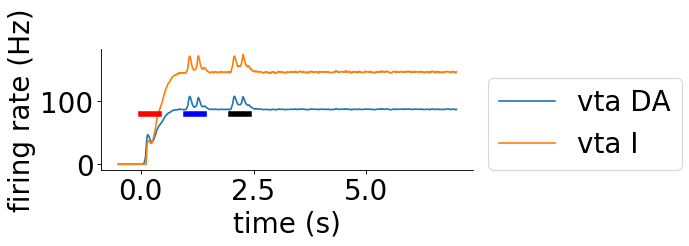

In [868]:

fig=plt.figure(figsize=(6,2), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

# plt.plot(dyn_da_rel[10000:])
plt.plot(np.arange((start_time-6)*brian2.second,(end_time-6)*brian2.second,PARAMS['dt']),R_vta[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),0])
plt.plot(np.arange((start_time-6)*brian2.second,(end_time-6)*brian2.second,PARAMS['dt']),R_vta[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),1])

plt.legend(['vta DA','vta I'],loc=(1.04,0))
# plt.plot(x[:,0,0])
# plt.plot(u[:,0,0])
# plt.plot(x[:,0,0]*u[:,0,0]/(PARAMS['x0']*PARAMS['u0']))
# plt.plot(x[:,0,0]*u[:,0,0])
# plt.plot(R[:,0,0])

axes = plt.gca()
# Plot the stimulation time
plt.plot([PARAMS['stim_on']-6*brian2.second,PARAMS['stim_off']-6*brian2.second],[80,80],color='r',linewidth=5.0)
# # Plot the distractor time
plt.plot([PARAMS['distract_on']-6*brian2.second,PARAMS['distract_off']-6*brian2.second],[80,80],color='b',linewidth=5.0)
plt.plot([PARAMS['ping_on']-6*brian2.second,PARAMS['ping_off']-6*brian2.second],[80,80],color='k',linewidth=5.0)

# Hide the right and top spines
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')

Text(0,0.5,'Cortical DA')

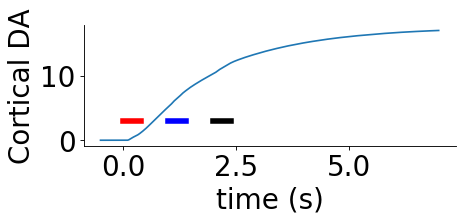

In [869]:
fig=plt.figure(figsize=(6,2), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

# plt.plot(dyn_da_rel[10000:])
plt.plot(np.arange((start_time-6)*brian2.second,(end_time-6)*brian2.second,PARAMS['dt']),dyn_da_rel_ctx[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1)])

# plt.legend(['vta DA','vta I'],loc=(1.04,0))
# plt.plot(x[:,0,0])
# plt.plot(u[:,0,0])
# plt.plot(x[:,0,0]*u[:,0,0]/(PARAMS['x0']*PARAMS['u0']))
# plt.plot(x[:,0,0]*u[:,0,0])
# plt.plot(R[:,0,0])

axes = plt.gca()
# Plot the stimulation time
plt.plot([PARAMS['stim_on']-6*brian2.second,PARAMS['stim_off']-6*brian2.second],[3,3],color='r',linewidth=5.0)
# # Plot the distractor time
plt.plot([PARAMS['distract_on']-6*brian2.second,PARAMS['distract_off']-6*brian2.second],[3,3],color='b',linewidth=5.0)
plt.plot([PARAMS['ping_on']-6*brian2.second,PARAMS['ping_off']-6*brian2.second],[3,3],color='k',linewidth=5.0)

# Hide the right and top spines
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
plt.xlabel('time (s)')
plt.ylabel('Cortical DA')



In [871]:
print(rewards[:30])

[0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [872]:
print(rewards[30:60])

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [873]:
print(rewards[60:90])

[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [874]:
print(c_VTA_DA_E1)


0.999612021304


In [875]:
print(c_VTA_DA_E2)


0.639516708209


In [877]:
stimulus_order_all_trials = np.random.randint(1,3,num_trials)

print(stimulus_order_all_trials)

[1 2 1 1 2 1 2 1 2 2 2 2 1 2 1 2 2 2 1 1 1 2 2 1 2 2 2 1 2 2 2 1 1 2 2 2 2
 2 1 2 2 1 1 1 2 2 2 1 2 1 2 1 2 2 1 2 1 1 1 2 1 2 2 1 2 1 1 2 1 1 1 1 1 1
 1 2 1 2 1 1 2 1 1 1 1 2 2 2 1 1]


In [834]:
rewarded_stim = np.concatenate((np.concatenate((np.ones((int(num_trials/3),1)), 2*np.ones((int(num_trials/3),1))), axis=0) , np.ones((int(num_trials/3),1))), axis=0)

print(rewarded_stim)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [835]:
print(rewarded_stim.shape)

(45, 1)


In [876]:
# Remove the run-in time 
R_all_trials_short = copy.deepcopy(R_all_trials[:,10000:,:,:])
R_vta_all_trials_short = copy.deepcopy(R_vta_all_trials[:,10000:,:])
dyn_da_rel_all_trials_short = copy.deepcopy(dyn_da_rel_all_trials[:,10000:])

data = {}

data.update({'R': R_all_trials_short}) # firing rates cortex
data.update({'R_vta': R_vta_all_trials_short}) # firing rates VTA
data.update({'da_rel': dyn_da_rel_all_trials_short}) # cortical dopamine availability
data.update({'rewards': rewards}) # reward history


sio.savemat('model_outputs/cortex_vta_learning_soltani_90trials.mat', data)

